# Irreducible mass of black holes

The irreducible mass of a black hole (BH) is defined as:

\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\end{equation}

For convenience, let us define $f= M_{\rm irr}/M$.

Now, let's generate some data supposing that $\chi$ follows a uniform distribution between 0 and 1, and $M$ is extracted from a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ks_2samp
from astropy.visualization.hist import hist as hhist
from astroML import stats as astroMLstats
from scipy import integrate

Once we generate the easiest thing to do is generate a histogram with a suitable bin width. We could use the so called Freedman-Diaconis rule:

$$ \Delta_{bin} = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7 \sigma_{G}}{N^{1/3}}$$

With $\sigma_{G} = 0.7413 (q_{75}-q_{25}) $ that can be evaluated with a function from the astroML library.

Text(0.5, 0, '$M_{\\mathrm{irr}}$')

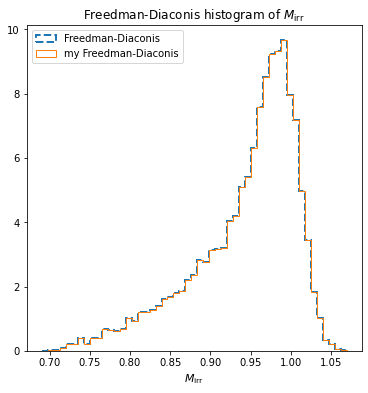

In [2]:
N_obj = 10000  
spin = np.random.uniform(0,1, size=N_obj)      #spin uniform extraction
M = norm.rvs(loc = 1, scale=0.02, size=N_obj)  #M normal extraction with mu = 1, sigma = 0.02
f = np.sqrt((1+np.sqrt(1-spin**2))/2)          #function f
M_irr = M*f                                    #irreducible mass
 
fig, ax = plt.subplots(1,1, figsize=(6,6))

#this function generates a Freedman-Diaconis histogram automatically
freedman_hist = hhist(M_irr, bins='freedman', density=True, histtype='step', label='Freedman-Diaconis', ls='--', lw=2) 

#here I try to do it by myself
sigma_G = astroMLstats.sigmaG(M_irr)         #sigma_G of M_irr
freed_width = 2/0.7413*sigma_G/N_obj**(1/3)  #bin width from Freedman rule
bins = np.arange(np.min(M_irr), np.max(M_irr), freed_width) #generating the 
bins = np.append(bins, bins[-1] + freed_width) #adding the last bin

ax.hist(M_irr, bins=bins, density = True, histtype='step', label='my Freedman-Diaconis')

ax.legend(loc ='upper left')
ax.set_title('Freedman-Diaconis histogram of $M_{\mathrm{irr}}$', fontsize=12)
ax.set_xlabel('$M_{\mathrm{irr}}$', fontsize=11)

To get a function from a histogram we can use the Kernel Density Estimation (KDE) technique. With this technique every single data is interpreted as a function with a given width and not like a delta function as we would usually do for a histogram.

Here I try with different functions like a 'tophat' (which is a sort of step function), gaussian, linear...

9.184436425440994 9.11510778362029 9.236342041581075


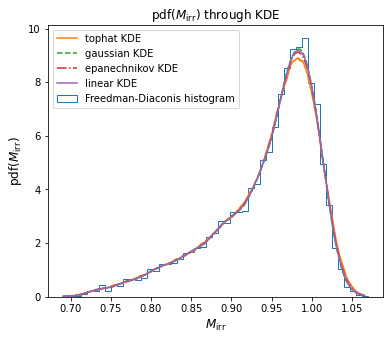

In [11]:
from sklearn.neighbors import KernelDensity

fig, ax = plt.subplots(1,1, figsize=(6,5))
x_grid = np.linspace(np.min(M_irr), np.max(M_irr), 1000)


def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

PDF_Mirr_tophat = kde_sklearn(M_irr,bandwidth=0.020,kernel="tophat")       #tophat KDE
PDF_Mirr_gauss  = kde_sklearn(M_irr,bandwidth=0.008,kernel="gaussian")     #gaussian KDE
PDF_Mirr_epan   = kde_sklearn(M_irr,bandwidth=0.021,kernel="epanechnikov") #epanechnikov KDE
PDF_Mirr_linear = kde_sklearn(M_irr,bandwidth=0.021,kernel="linear")       #linear KDE

freedman_hist = hhist(M_irr, bins='freedman', density=True, histtype='step', label='Freedman-Diaconis histogram')

#plotting
ax.plot(x_grid, PDF_Mirr_tophat, label = 'tophat KDE') 
ax.plot(x_grid, PDF_Mirr_gauss, label = 'gaussian KDE', ls='--')
ax.plot(x_grid, PDF_Mirr_epan, label = 'epanechnikov KDE', ls='-.')
ax.plot(x_grid, PDF_Mirr_linear, label='linear KDE', ls= '-')
ax.legend()
ax.set_xlabel('$M_{\mathrm{irr}}$', fontsize = 12)
ax.set_ylabel('pdf($M_{\mathrm{irr}}$)', fontsize=12)
ax.set_title('pdf($M_{\mathrm{irr}}$) through KDE')

print(np.max(PDF_Mirr_linear), np.max(PDF_Mirr_epan), np.max(PDF_Mirr_gauss))

In general increasing the bandwidth value one can notice how the generated KDE function results smoother even if it gradually disentangles from the histogram bars. In the plot above the values of the bandwidths are chosen by imposing a similar smothness in the left tail of the function. We can see that in general the tophat distribution seems the worst one to describe data in the surrounding of the peak, while linear and epanechnikov distribution seem to be the best ones.

Now, to prove whether two variables are generated from the same distribution we can use the Kolmogorov-Smirnov (KS) test.
This test aims to find the maximum distance between the cdf of two variables and compute the probability of extracting the value of a variable in correspondence of this point from the distribution of the other one.

In the following cells I'm computing the KS test between $M_{irr}$ - $f$ and $M_{irr}$ - $M$ as a function of the $\sigma$ value of the normal distribution of M.

In [4]:
#changing the sigma
sigma=np.logspace(-6,6,1000)

KS_value_Mirr_f = np.zeros(len(sigma))
KS_value_Mirr_M = np.zeros(len(sigma))

for j in range(len(sigma)): 
    spin_s = np.random.uniform(0,1, size=N_obj)
    M_s = norm.rvs(loc = 1, scale=sigma[j], size=N_obj) #re-defining M
    f_s = np.sqrt((1+np.sqrt(1-spin_s**2))/2)  
    M_irr_s = M_s*f_s
    
    KS_value_Mirr_f[j] = ks_2samp(M_irr_s, f_s)[1]      #KS between M_irr and f
    KS_value_Mirr_M[j] = ks_2samp(M_irr_s, M_s)[1]      #KS between M_irr and M

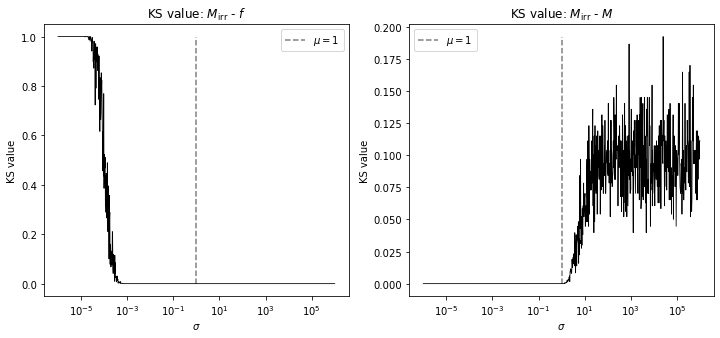

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(sigma, KS_value_Mirr_f, c='black', lw=0.8)
ax[0].vlines(x= 1, ymin=0, ymax=1, ls='--', color='gray', label='$\\mu = 1$')
ax[0].set_xlabel('$\\sigma$')
ax[0].set_ylabel('KS value')
ax[0].set_xscale('log')
ax[0].set_title('KS value: $M_{\mathrm{irr}}$ - $f$')
ax[0].legend()

ax[1].plot(sigma, KS_value_Mirr_M, c='black', lw=0.8)
ax[1].vlines(x= 1, ymin=0, ymax=np.max(KS_value_Mirr_M), ls='--', color='gray', label='$\\mu = 1$')
ax[1].set_xlabel('$\\sigma$')
ax[1].set_ylabel('KS value')
ax[1].set_title('KS value: $M_{\mathrm{irr}}$ - $M$')
ax[1].set_xscale('log')
ax[1].legend()

From the two plots above we clearly see that if $\sigma << \mu$ then $M_{irr}$ distribution if closer to that of $f$, while for $\sigma >> \mu$ $M_{irr}$ distribution is more similar to that of $M$. However this point can be proven by computing the density functions of all variables: $f$, $M$ and $M_{irr}$ for a given value of $\sigma$, in this case 0.02.

Analitically we can fin the pdf($f$) from the formula:

$$ \mathrm{pdf}(f) = |\frac{df}{d\chi}|^{-1} \mathrm{pdf}({\chi}) $$

Since the distribution of $\chi$ is uniform between 0 and 1 then: $\mathrm{pdf}(\chi) = 1$.

And from the definition of $f$ we find:

$$ \mathrm{pdf}(f) = 2\frac{2f^2-1}{\sqrt{1-f^2}} $$

Text(0.5, 1.0, '$f$ distribution function')

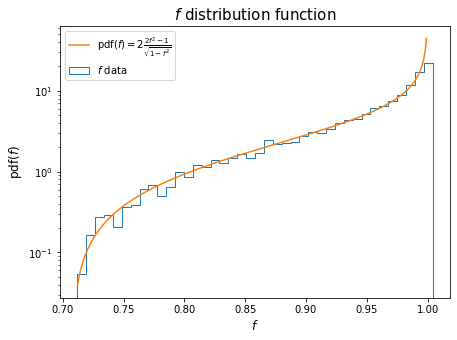

In [6]:
#cheking the f distibution
fig, ax = plt.subplots(1,1, figsize=(7,5))

x_f = np.linspace(np.min(f), 0.999, 1000)
f_freed = hhist(f, bins='freedman', density=True, histtype='step', label='$f$ data') #freedman histogram for f data

def pdf_f(f):
    return 2*(2*f**2-1)/(1-f**2)**0.5    #pdf(f) as found analytically

ax.plot(x_f, pdf_f(x_f), label = '$\mathrm{pdf}(f) = 2\\frac{2f^2-1}{\\sqrt{1-f^2}}$')
ax.legend()

ax.set_yscale('log')
ax.set_xlabel('$f$', fontsize=12)
ax.set_ylabel('pdf($f$)', fontsize=12)
ax.set_title('$f$ distribution function', fontsize=15)

Then, to find the pdf($M_{irr}$) we use the theorem that ??

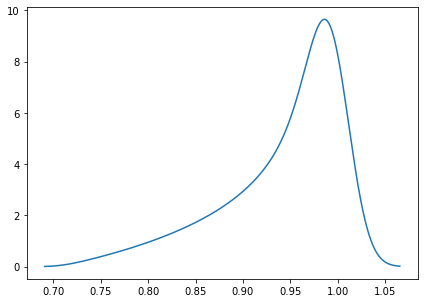

In [7]:
def int_func(x, M_irr, mu, sigma):
    return np.exp(-(M_irr/x - mu)**2/(2*sigma**2))* (2*x**2-1)/(x*(1-x**2)**0.5)  #integrand function

integral = np.zeros(len(x_grid))
M_irr_pdf= np.zeros(len(x_grid))

for i in range(len(x_grid)):
    integral[i] = integrate.quad(int_func, 1/np.sqrt(2), 1, args = (x_grid[i], 1, 0.02))[0] #integral
    M_irr_pdf[i]= np.sqrt(2/np.pi)/0.02*integral[i] #M_irr pdf

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(x_grid, M_irr_pdf)


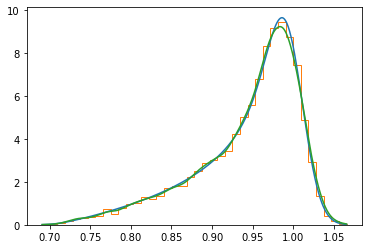

In [10]:
plt.plot(x_grid, M_irr_pdf)
plt.hist(M_irr, histtype='step', density=True, bins=40)
plt.plot(x_grid, PDF_Mirr_gauss)